In [180]:
# using the packages

import Plots
import PlotlyBase
import Colors
import CSV
import DataFrames
import Random

using LinearAlgebra

# selecting the backend

#Plots.PlotlyBackend()
#Plots.plotly()
#Plots.pyplot()
Plots.gr()

Plots.GRBackend()

In [356]:
# reading in the data
train_data = Matrix( CSV.read("input.txt"));             # there is no HEADER to the CSV file

# when using PLOTLY backend, it is advisable to reduce the number of points
#train_data = train_data[1:150,:]

n_data,dim_data = size(train_data)

(2399, 3)

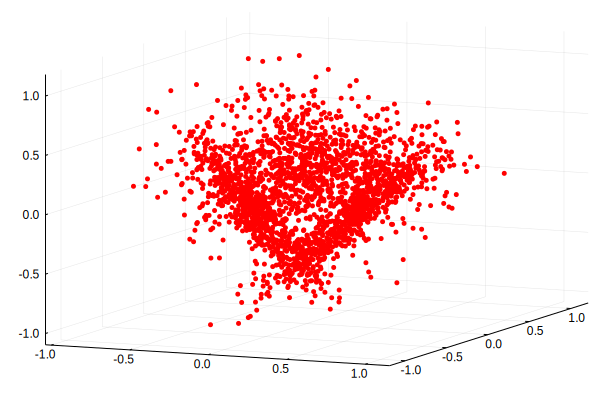

In [357]:
c_all = rand(Colors.RGB{Float64},n_data)
p=Plots.scatter3d(train_data[:,1],train_data[:,2],train_data[:,3],
    markersize=2,
    markercolor= :red, #c_all,
    markerstrokecolor=:red, #c_all,
    legend=false
)
# the colors are rrandom to reflect the _heterogeneity of the data
# if you want to plot, then you can use:
# -> Plots.savefig("test.png") # where the extension determines the file-type
p

# Implementing the EM algorithm

The EM algorithm is an iterative parameter estimation.

After an initial step - choosing randomly the centers and usually equal weights - the algorithm iterates the WEIGHT estimation and the parameter estimation steps.


In [358]:
# INITIALISING THE parameters of the algorithm

# number of clusters
n_clus = 4

# the code below provides a set of - n_clus - distuingishable colors
col_vec = Colors.distinguishable_colors(n_clus)

function init_mixture_parameters(tr_d,num_cls)
    n_data,dim_data = size(tr_d)
    # the centres are chosen randomly from the data
    r_p = Random.randperm(n_data)

    # returning the three entities
    (   [tr_d[(ii * 50 + 1),:] for ii= 1:num_cls],
        [diagm(ones(dim_data)) for _ in 1:num_cls], 
        ones(num_cls)/num_cls )
end

cent_clus, cov_clus, pr_clus = init_mixture_parameters(train_data,n_clus);

In [359]:
# compute the class-conditional probabilities - based on MODEL PARAMETERS
function compute_gamma(train_data, cent_clus, cov_clus, pr_clus)
    n_clus = length(cent_clus)       # we find the number of clusters
    @assert n_clus == length(cov_clus) == length(pr_clus)
    
    # init the weights
    gamma = -ones(n_data,n_clus)
    for kk = 1: n_clus
        dd = (train_data .- cent_clus[kk]')            # z <- (x-mu)
        dd = sum( (dd/cov_clus[kk]) .* dd , dims=2)    # d <- z^T*cov^(-1)*z
        gamma[:,kk] = pr_clus[kk] * exp.(-dd/2) / sqrt(det(2*pi*cov_clus[kk]) )
        
    end
    
    gamma = gamma ./ sum(gamma,dims=2) # we use broadcasting
end;
# the line below is to test the function -- remove semicolons to see the results
gamma = compute_gamma(train_data, cent_clus, cov_clus, pr_clus);

In [360]:
# helper function for visualising the data
""" the function returns the mixture of colors from col_vec, where in each row
    the color is mixed according to the respective coefficient.
    There should be as many colors as many columns in the GAMMA matrix.
"""
function compute_colors_gamma(gamma, col_vec)
    #getting the parameters
    n_clus = size(gamma,2)
    @assert n_clus<=length(col_vec)
    
    # iterating for columns
    col = col_vec[end]
    den = gamma[:,end] .+ 1e-20
    
    for kk = n_clus-1:-1:1
        den += gamma[:,kk]
        w = gamma[:,kk] ./ den
        col = Colors.weighted_color_mean.(w,col_vec[kk],col)
    end
    col
end
# for testing
compute_colors_gamma(gamma,col_vec);

In [361]:
# compute the new parameters -- based on CLASS-CONDITIONAL probabilities
function compute_pars(train_data, gamma )
    # finding the number of clusters -- it is the number of columns
    n_clus = size(gamma,2)
    
    # initialisation of the parameters
    cent_clus = [  zeros(dim_data)      for _ in 1:n_clus]
    cov_clus  = [diagm(zeros(dim_data)) for _ in 1:n_clus]
    pr_clus   = zeros(n_clus)
    total_pr  = sum(gamma)
    
    # computation
    for kk = 1: n_clus
        # compute the mean
        cc = sum(train_data .* gamma[:,kk] , dims=1)[1,:]
        cent_clus[kk] = cc ./ sum( gamma[:,kk])
        # compute the covariance
        cc = ( train_data .- cent_clus[kk]' )
        cov_clus[kk] = cc' * (cc .* gamma[:,kk]) ./ sum( gamma[:,kk])
        # compute the weights
        pr_clus[kk] = sum(gamma[:,kk]) / total_pr
    end
    ( cent_clus, cov_clus, pr_clus )
end

# tesing the function
cent_clus, cov_clus,pr_clus = compute_pars(train_data, gamma);

In [362]:
# iterating the EM algorithm
for ii = 1:100
    gamma = compute_gamma(train_data, cent_clus,cov_clus,pr_clus)
    cent_clus, cov_clus,pr_clus = compute_pars(train_data, gamma)
end
print(pr_clus)

[0.24760346138245787, 0.25274002788881805, 0.2454631214307891, 0.25419338929793495]

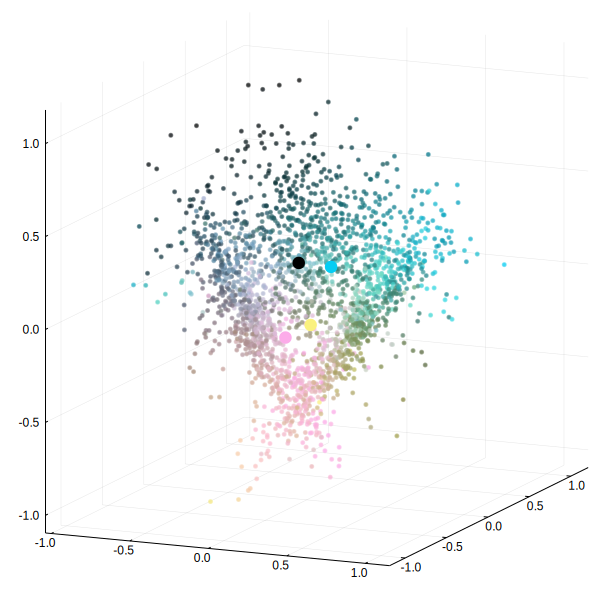

In [355]:
col_gamma = compute_colors_gamma(
    compute_gamma(train_data, cent_clus,cov_clus,pr_clus),
    col_vec)

# @show cent_clus
# @show cov_clus
# @show pr_clus

p = Plots.scatter3d(train_data[:,1],train_data[:,2],train_data[:,3],
    markersize=2,
    markercolor= col_gamma, markerstrokecolor= col_gamma, legend=false,
    #markercolor= :black, markerstrokecolor=:black, legend=false,
    markeralpha = 0.5)

Plots.scatter3d!(p,
    [c[1] for c = cent_clus],
    [c[2] for c = cent_clus],
    [c[3] for c = cent_clus],
    markersize=6, markercolor=col_vec, markerstrokecolor=col_vec, legend=false,
    size = (600,600)
)

In [315]:
dists = [
    (KL(cent_clus[i], cov_clus[i], cent_clus[j], cov_clus[j]), i, j) 
    for i = 1 : (n_clus-1) for j = (i + 1) : n_clus
]

6-element Array{Tuple{Float64,Int64,Int64},1}:
 (0.983010894376779, 1, 2)
 (1.0657877026850517, 1, 3)
 (0.5034576824678989, 1, 4)
 (1.0661961308912942, 2, 3)
 (0.08695147306235938, 2, 4)
 (1.072934180633676, 3, 4)

# Your task

## Please study the code from above

Observe the LOOP that -- after an initialising step -- first (re-)computes the conditional probabilities that is denoted GAMMA, and then -- based on these computed respoonsibilities -- recomputes the parameters of the distributions.

 (2p)

## Implementing the 2D case

Your task is to apply the EM algorithm for two-dimensional data

The steps:
 - generating the centers of the clusters (done);
 - generating the data based on the mixture probabilities and the individual components;
 - running the EM algorithm to finding paramters;
 - plotting the clusters with the color-coding.

  (5p)

## Improving the EM algorithm

You will see -- e.g. in output 430 (see the PDF version of the notebook) -- that often the EM algorithm is getting stuck in a local mninima where the mixture centres are close to one another and other clusters are grouped together.

__Suggestion:__<br/>
Implement a version of the EM algorithm that:

  - (1) measures the pairwise distence between cluster centres and selects the closest pair,
  - (2) measures the condensed nature of clusters and the "loosest" one is selected,
  - (3) one of the centres from (1) is moved to the vicinity of the centre of (2).

  (5p)
  
Explain the working of the algorithm with your words.

  (3p)


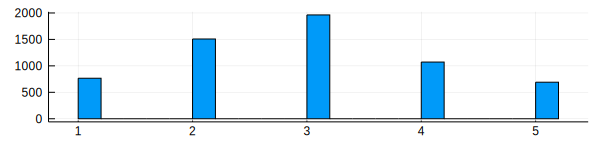

In [379]:
# a helper function
""" rand_weight(cum_pr) returns a random index from 1 to the length of the 
    vector "cum_pr" - where cum_pr is the cumulated probability.
    E.g. if there are 5 mixture components with weights [1/8, 1/4, 1/3, 1/6, 1/8]
    then the approximate numbers from 1 to 5 will be: [750, 1500, 2000, 1000, 750]
"""
rand_weight(cum_pr) = findnext( cum_pr .> rand(), 1)

t = [1/8, 1/4, 1/3, 1/6,1/8]
Plots.histogram([rand_weight(cumsum(t)) for _ in 1:6000],size=(600,150),legend=false)

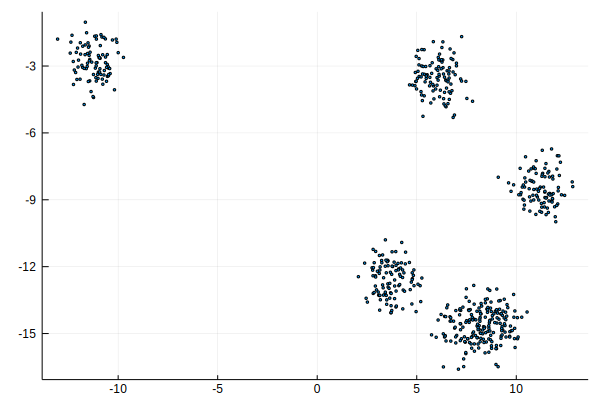

In [380]:
# generating the data:

# these are the parameters that are used in the generation process
n_clus   = 6
dim_data = 2
cent_clus = [(2*rand(dim_data) .- 1)*15 for _ in 1:n_clus]
cov_clus  = [  diagm(ones(dim_data))/2  for _ in 1:n_clus]
pr_clus   = ones(n_clus) ./ n_clus
n_data = 600


# generating the data
lims = cumsum(pr_clus)
sq_cov_clus = [cholesky(cov,check=false) for cov in cov_clus]

# one solution: => using functional features
#train_data = hcat(map(1:n_data) do _
#    ii = rand_weight(lims)
#    sq_cov_clus[ii].U *randn(dim_data) .+ cent_clus[ii]
#    end...
#)

# second solution using a for
train_data = NaN*zeros(n_data,dim_data)
for rr in 1:n_data
    ii = rand_weight(lims)
    train_data[rr,:] = (sq_cov_clus[ii].U *randn(dim_data) .+ cent_clus[ii])'
end

Plots.scatter(train_data[:,1], train_data[:,2], legend=false, markersize=1)

In [381]:
print(train_data)
cent_clus = [train_data[(ii * 50 + 1),:] for ii= 1:6]


[5.249588457096017 -2.997703340052679; 6.67446386391103 -2.2346525519191935; -10.995566314126004 -3.2725344944260693; 6.189518871179093 -2.742691090287626; -11.647324908271477 -1.0350621835374432; 7.906357221298178 -14.365292328859729; 5.17054086960698 -12.853818031675099; 6.669825226533074 -14.247311488929157; 7.9705008327592 -14.386126618539217; 4.952285466582573 -3.6974857533617493; 3.710500071789702 -13.751633681774223; 8.354030821859125 -14.692113538093922; 4.831365642401855 -12.392200120992285; 2.5203031363273145 -13.589533486616446; 6.472794147538315 -4.827525621859679; 5.323181005817843 -3.0219314045667627; 9.00172581117455 -15.53523001595253; 9.320849457467087 -14.840657362228939; 7.566849845584115 -15.23760216418387; 7.255807287558024 -1.6817456193281002; 7.759333369460957 -15.657150127937346; 2.0685813233159145 -12.450139771263517; 9.240493877356197 -15.116314454914285; 9.269860085893187 -14.871753996535235; 4.425457946714957 -11.87425917335051; 6.186353964022707 -4.08484546

 -3.2009023730007677; 8.798466951603226 -14.191636320866408; 3.4685622596918324 -13.290195917950909; 8.493345083952912 -15.379237359039617; 8.625485008336595 -14.757454811373348; -9.99705453232553 -2.4016142238776355; 8.169896894163907 -14.007923005587662; 6.399194330447362 -14.229119444855547; 3.3130108981127435 -12.949177801365439; 8.552815725229395 -14.048538724422142; -11.656272763862857 -2.0532639195716955; 7.153182848251836 -14.160906277702908; 11.818958234508269 -8.969561788289093; 3.23599177280668 -11.723479914976174; 9.391744640099091 -14.302861593135548; 8.56473421654266 -13.933661823012107; -11.77954175576548 -2.1122458796087136; 7.183192779382743 -14.557374634139334; -10.401936092109311 -3.3388451013946043; -10.184702665189825 -4.066754877579095; 7.007978217497517 -15.08263596014104; 3.5285107212693267 -11.711391128498981; -10.79547291362032 -3.588395053469573; 6.5554484017722805 -13.71720055861223; 9.194758905123887 -13.518875826353982; 3.1297207856799405 -13.2974864052577

; -10.917478270555053 -3.1222573314446427; -11.446442383945794 -2.765588992141901; 9.245110324805953 -14.106450693897363; 5.11103705549543 -2.9484557838689947; 8.772661548246301 -15.365247704012997; -10.714127330568855 -1.7140384982259487; 6.61144394190423 -3.35716745268731; 7.782853501378298 -15.133270247056519; 11.614863787411473 -8.746617379627178; 5.806402394229002 -3.8240277486816283; 5.281876186107629 -4.551778294701301; 4.088190817955736 -12.099853294129105; 8.617415382125056 -14.6507734958521; 10.732229607721493 -9.057441719904492; 3.959469806235414 -11.940618821943444; 6.4313742546967605 -4.7829272600025545; -13.041406396081026 -1.7930448649270756; 7.804075982068572 -4.581234804158509; 2.4571038582579083 -13.417700210878845; 6.3657732843906 -4.698320506390846; 3.7147061032655513 -13.20275831398413; 3.1724102956570004 -13.48537701303718; 5.479126487999514 -3.4502627523609344; 6.109328839543968 -2.724430251012806; 7.463613112423617 -15.852706498928978; 7.172879895741324 -13.8896

6-element Array{Array{Float64,1},1}:
 [3.68552481821703, -13.170970664116128]
 [8.1377752770922, -14.818360205448469]
 [10.997684921057433, -7.248244498563734]
 [5.819295504987929, -4.1151902987366915]
 [8.049695485676592, -15.183060393863494]
 [6.961626354829299, -15.421454766062187]

In [382]:
# for visualisation: getting n_clus - distinguishable - colors
print(n_clus)

col_vec = Colors.distinguishable_colors(n_clus)

# initialising the mixture parameters
cent_clus, cov_clus, pr_clus = init_mixture_parameters(train_data, n_clus);

6

In [383]:
# iterating the EM algorithm
print(length(cent_clus))

for ii = 1:100
    gamma = compute_gamma(train_data, cent_clus, cov_clus, pr_clus)
    print("\n")
    print(gamma[1:10, :])
    print("\n")
    cent_clus, cov_clus, pr_clus = compute_pars(train_data, gamma)
end
# the line below is to get an impression about the "even-ness" of the clustering
pr_clus;

6
[2.1712373095919233e-23 1.544374029114017e-32 1.7528641109542702e-11 0.9999999999824712 2.4912929262933616e-34 1.5437710302404156e-34; 1.0358888421958324e-27 1.1927617638517665e-34 2.570141988498737e-9 0.999999997429858 1.2848822596986404e-36 1.4083355446499119e-37; 2.9629370828304127e-7 1.285177160413326e-47 1.2112313771398444e-47 0.9999997037062917 9.58481953569255e-49 3.0110707861388905e-41; 2.9023956705578004e-25 8.908215811401452e-33 1.0247404960385316e-9 0.9999999989752595 1.2053622528892433e-34 2.5276469396329174e-35; 1.8879803056624238e-15 1.1277195251860225e-58 3.741106577784853e-52 0.9999999999999981 3.938821762793174e-60 1.475142276323479e-52; 3.395178342359204e-5 0.4497486642059779 4.3154385419526577e-14 8.88855273647432e-25 0.36265649023110963 0.18756089377944576; 0.9684833076055839 0.005455953998893689 1.9504600877177538e-14 6.505208514708758e-17 0.0032258930848409577 0.022834845310662037; 0.0063592965221373155 0.2819444362182834 1.9243033208698003e-15 3.463426997240112

[1.894925801948079e-36 6.0080407918510555e-64 1.2067582363276644e-27 1.0 1.2642247272175405e-61 3.42228091352364e-57; 2.18298015915708e-45 1.3714490011274637e-69 2.999017112327657e-24 1.0 3.592339399040583e-66 1.1986604546281175e-63; 1.774039631408359e-127 1.2885091728442507e-173 2.8617816840891433e-230 1.0 1.2303582567267768e-165 2.3501878681792084e-160; 2.1667205821187676e-40 5.67583027118568e-65 3.717791520342115e-24 1.0 3.768890027174647e-62 5.099124111416903e-59; 2.4805245931332823e-151 2.212745334234662e-205 1.1699033231208715e-252 1.0 3.7216990983186844e-197 3.874231639566025e-188; 6.988476962865349e-10 0.4653912477708246 2.381803737770988e-21 1.795152628484902e-47 0.3559281738271249 0.17868057770320284; 0.9955213434028423 0.00011914590771650407 1.7861337128903542e-25 3.1944868762895846e-35 0.00014426932078201365 0.004215241368659266; 3.812810490022724e-5 0.1574346759816716 7.465328453686069e-25 2.7532297361216904e-46 0.18060991144753114 0.661917284465897; 3.5718784458694126e-10

[1.9423439708023937e-36 7.659724533598424e-64 1.2067582364484072e-27 1.0 1.5847969994764835e-61 4.10841069900836e-59; 2.13699649665906e-45 1.4269420248415388e-69 2.9990171128426764e-24 1.0 1.3774452944809605e-65 6.081878430431979e-66; 6.606396560225603e-127 1.1617223669656183e-195 2.8617816837842826e-230 1.0 8.513520267653907e-188 5.886383720301819e-216; 2.1494985509809714e-40 7.1616514949631216e-65 3.717791520824576e-24 1.0 9.701479338437593e-62 5.4031861378920194e-61; 1.2615907242478277e-150 2.767723951340651e-227 1.1699033230271052e-252 1.0 2.6665053113203412e-220 1.1063448630939023e-247; 8.739798837571618e-10 0.44792641479829254 2.691273651318845e-21 2.0283984322569446e-47 0.3830092722634609 0.16906431206426673; 0.9976115213321738 1.3115364909847506e-5 1.7703834839541423e-25 3.166317708129198e-35 2.650546000663218e-5 0.0023488578429097426; 3.4947739813906686e-5 0.04943409828791837 6.434402222580147e-25 2.3730218486102266e-46 0.09156375405041367 0.858967199921854; 4.4369701877375095

[1.9441704818311838e-36 1.5499152305977883e-64 1.2067582364693472e-27 1.0 4.1434001902578934e-62 4.032324599605767e-59; 2.1300927036155332e-45 1.610206930499815e-70 2.9990171129486513e-24 1.0 4.89395473512213e-66 1.196753880985618e-65; 7.483895454227097e-127 1.6282915256535922e-196 2.8617816837599647e-230 1.0 2.187504562505947e-194 9.900641710230478e-222; 2.1452831308617023e-40 1.1052689221816322e-65 3.7177915209178296e-24 1.0 3.2162363293979516e-62 8.257715295016927e-61; 1.4699750903741056e-150 3.7380799320646186e-228 1.1699033230038655e-252 1.0 1.528353697204049e-227 2.6338805807040307e-254; 8.926964800996041e-10 0.4369112305874772 2.722185248671705e-21 2.0516963362406423e-47 0.3870378703059571 0.17605089821386916; 0.9978591997168612 1.1226264761929873e-5 1.7689169805999484e-25 3.1636948775441094e-35 1.6919776731827984e-5 0.0021126542416450658; 3.472746049847132e-5 0.043061461069388775 6.356577013636616e-25 2.3443197382590118e-46 0.08273747790522654 0.8741663335648863; 4.531186512186

[1.9436339189392293e-36 2.741429495859186e-65 1.2067582365007875e-27 1.0 2.9175862083206396e-63 1.734009179240399e-59; 2.1273295335757216e-45 1.1050889801328846e-71 2.9990171131135573e-24 1.0 3.6567683013409335e-67 8.268143730393058e-66; 7.731484298404646e-127 1.4510047085625348e-196 2.8617816837265465e-230 1.0 2.5635928625700347e-199 1.0157438769243526e-223; 2.1432213468258155e-40 1.218186345493699e-66 3.717791521061183e-24 1.0 2.5686465614768645e-63 4.9122831030407293e-61; 1.5290369601474886e-150 5.152192168559111e-228 1.1699033229644024e-252 1.0 2.977003317852747e-233 5.7473654516202835e-257; 9.023172524898586e-10 0.42324113541063707 2.7443160887924582e-21 2.0683762307515177e-47 0.389989027735858 0.18676983595118762; 0.9979928912281608 1.0218821887430381e-5 1.768620453469821e-25 3.163164540593692e-35 1.2114875292208564e-5 0.0019847750746594364; 3.4645335994630086e-5 0.03740714835628876 6.331752255922002e-25 2.3351643120447956e-46 0.07938745308284172 0.8831707532248748; 4.58149153073

[1.942543968488596e-36 4.799491445431086e-66 1.2067582365438525e-27 1.0 2.8741325876817105e-65 4.962954228862046e-60; 2.1251553460925703e-45 5.986140300121845e-73 2.9990171133386582e-24 1.0 2.844005740595456e-69 3.771780810549335e-66; 7.85923311685917e-127 1.4417182775256387e-196 2.8617816836747093e-230 1.0 3.8885389539544254e-204 2.615535312931751e-225; 2.1414025928678418e-40 1.1717268993429776e-67 3.7177915212572065e-24 1.0 2.5683196201006195e-65 1.9613123165138366e-61; 1.5590400231136565e-150 1.1085712605900886e-227 1.1699033229080976e-252 1.0 3.843983401573909e-239 2.6363900628590114e-259; 9.129191141471524e-10 0.4065509007420586 2.7727311872238173e-21 2.0897925367361936e-47 0.39377157482858516 0.1996775235164372; 0.9981190505063335 9.190467079481373e-6 1.7685456905403628e-25 3.1630308271343805e-35 8.669343133719026e-6 0.0018630896834533352; 3.458825795954403e-5 0.031442025149643636 6.316298821398267e-25 2.3294650505361767e-46 0.07750918954182447 0.8910141970505724; 4.6375679484002

[1.940706881357931e-36 9.785414006174137e-68 1.2067582366348552e-27 1.0 4.9466552719726574e-70 4.330888644443332e-61; 2.1203676756986188e-45 1.1794874625316668e-75 2.9990171138121984e-24 1.0 1.878392820828112e-74 8.821741706191118e-67; 8.210209545503343e-127 4.524262019726012e-197 2.861781683557117e-230 1.0 9.393234293193942e-213 1.1059101642283397e-229; 2.1375628445355064e-40 7.352937206788193e-70 3.717791521670204e-24 1.0 3.631553271787543e-70 3.444213943724879e-62; 1.6428251237681396e-150 1.213383931868893e-227 1.169903322789275e-252 1.0 5.488586244593237e-250 2.813606913014509e-265; 9.382888466901442e-10 0.37429531142852746 2.8395509885788464e-21 2.1401542596527343e-47 0.40209948560858944 0.22360520202459444; 0.9983761198957791 7.253804228123158e-6 1.7682468781320124e-25 3.16249640228878e-35 4.6510243848496185e-6 0.0016119752756077832; 3.449537149354027e-5 0.02219442519388182 6.286150410221706e-25 2.3183462484333747e-46 0.07408456303487443 0.9036865163997502; 4.771499850306306e-10 

[1.939625448417581e-36 1.8848085335529262e-69 1.2067582367147865e-27 1.0 4.077230654493241e-74 6.919018881094983e-62; 2.1157106253933833e-45 3.200986603432471e-78 2.9990171142272993e-24 1.0 5.230172587822636e-79 3.581843055739613e-67; 8.649917631795424e-127 2.3873287074035475e-198 2.8617816834491465e-230 1.0 6.032859421923819e-219 1.7566289632060578e-234; 2.1340341599339915e-40 5.401852250506119e-72 3.7177915220324524e-24 1.0 2.1681870725186095e-74 1.0495342827118284e-62; 1.7497697034748954e-150 1.1821562211860992e-228 1.1699033226840875e-252 1.0 6.8218667446194165e-258 1.6655260428899825e-271; 9.634214325756458e-10 0.34686327763710384 2.903359150090883e-21 2.188246125941531e-47 0.4104863025739988 0.24265041882547594; 0.9985934679519456 5.552315029919119e-6 1.7677739976648977e-25 3.1616506581519916e-35 2.9513567563330793e-6 0.001398028376268281; 3.442916406350441e-5 0.01626352345681425 6.25856067034469e-25 2.3081710901342305e-46 0.07162375405429117 0.9120782933248311; 4.904893725038961

[1.9386693017044684e-36 3.927799379889645e-72 1.2067582368384968e-27 1.0 2.0373600080722677e-79 9.538982018601875e-63; 2.108530106367427e-45 4.1181026026076595e-82 2.999017114867475e-24 1.0 4.172541217699753e-85 2.3764827965957892e-67; 9.468235711709477e-127 3.6834172225709637e-202 2.861781683271861e-230 1.0 8.912751423650416e-226 3.0479288649450185e-242; 2.128799147229675e-40 2.934786789370163e-75 3.7177915225918944e-24 1.0 5.560904286544084e-80 4.1134589200571213e-63; 1.9526891520645362e-150 3.191264110685216e-232 1.1699033225198543e-252 1.0 1.1876486784357968e-266 2.3264314726797397e-281; 1.002897599937759e-9 0.3011575350947599 3.0005805575062942e-21 2.2615213749120983e-47 0.428174320021338 0.2706681438810046; 0.9988805462029139 3.0343904163890753e-6 1.7668345307247167e-25 3.1599704270801944e-35 1.8342204803782454e-6 0.0011145851861895345; 3.4376721952441634e-5 0.009454129696934637 6.22241209601985e-25 2.294839414200768e-46 0.07034020545225346 0.9201712881288595; 5.118446503745987e-

[1.938403522007126e-36 1.1838902959838027e-73 1.206758236924363e-27 1.0 9.224823371732373e-82 7.386070517490301e-63; 2.1043254580231904e-45 2.3824688630812233e-84 2.9990171153095575e-24 1.0 5.443702252654701e-88 5.756379367115485e-67; 1.002632254909146e-126 2.178179322108225e-206 2.861781683138313e-230 1.0 2.706835976140669e-228 1.4355252287684982e-246; 2.125817505750613e-40 4.0004000159194645e-77 3.7177915229788966e-24 1.0 1.4591105851338374e-82 6.478189729754558e-63; 2.0935866740203994e-150 3.129784862077382e-236 1.1699033224043425e-252 1.0 9.607401234549812e-270 8.120275810008772e-287; 1.0254687667144352e-9 0.2640085048281795 3.054203689600251e-21 2.301936839364159e-47 0.44703247706261673 0.288959017083735; 0.9990212303165208 1.6245660246890597e-6 1.766182978090912e-25 3.158805129061864e-35 1.631997873155712e-6 0.0009755131195812162; 3.44119831901969e-5 0.005961440614520873 6.212051119444583e-25 2.291018262083697e-46 0.07220333138948376 0.9218008160128052; 5.24580992659096e-10 0.288

[1.9391860181029473e-36 6.557278913822453e-75 1.206758237059582e-27 1.0 4.44081331231789e-82 1.4801550644090845e-60; 2.1020531432180914e-45 1.797612228846845e-86 2.9990171160003404e-24 1.0 2.2153855121633124e-89 5.392040501878528e-64; 1.0488761603895778e-126 3.3706276999630734e-216 2.8617816828970226e-230 1.0 9.12533165461332e-227 6.267770727518575e-246; 2.124473177134562e-40 8.315869276125539e-79 3.7177915235853635e-24 1.0 1.723667138516223e-83 2.6962563285509133e-60; 2.212471419789768e-150 2.6020502919467506e-245 1.169903322217397e-252 1.0 8.549316608438997e-267 7.673772508887375e-286; 1.0340188277092729e-9 0.19501427177082722 3.0689457310724326e-21 2.3130478351474523e-47 0.5000368765058776 0.3049488506892763; 0.9990304035526927 3.789800811709261e-7 1.765537511912336e-25 3.1576507161065416e-35 2.387692965609933e-6 0.0009668297742605012; 3.478749857826786e-5 0.0023225785157416196 6.266794891497891e-25 2.3112078854807782e-46 0.0835741884286688 0.9140684455570114; 5.312223383610438e-10 

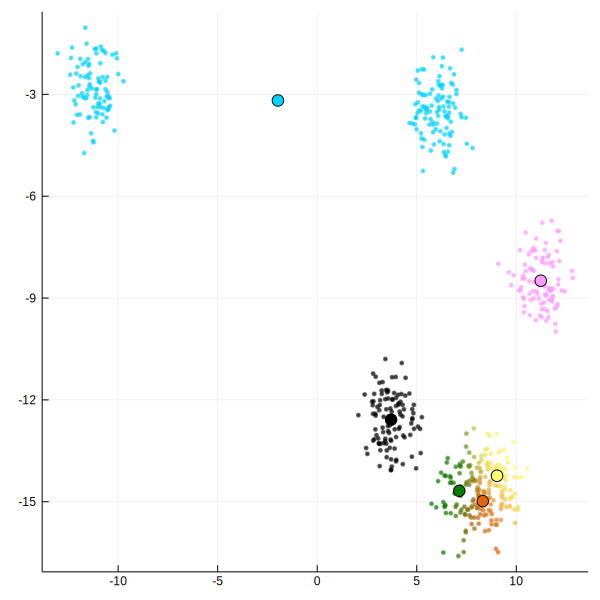

In [384]:
col_gamma = compute_colors_gamma(
    compute_gamma(train_data, cent_clus,cov_clus,pr_clus),
    col_vec)

p = Plots.scatter(train_data[:,1],train_data[:,2],
    markersize=2,
    markercolor= col_gamma, markerstrokecolor= col_gamma, legend=false,
    markeralpha = 0.5)
Plots.scatter!(p,
    [c[1] for c = cent_clus],
    [c[2] for c = cent_clus],
    markersize=6, markercolor=col_vec, markerstrokecolor=:black, legend=false,
    size = (600,600))

In [385]:
col_vec

In [386]:
# measuring distances
cent_clus

6-element Array{Array{Float64,1},1}:
 [3.710218882576678, -12.58273539189279]
 [9.034509772916463, -14.235581895351476]
 [11.229296460877002, -8.48932538984379]
 [-1.9731278065934583, -3.1802933334298564]
 [8.315115367448655, -14.984705698703761]
 [7.135588202762592, -14.678813607918288]

In [387]:
cov_clus

6-element Array{Array{Float64,2},1}:
 [0.46567642581473073 -0.031460194377901325; -0.031460194377901325 0.5734522370343368]
 [0.43166584494338867 -0.1260459394614866; -0.1260459394614866 0.3640426489171578]
 [0.4815459725770726 -0.0200408414324356; -0.02004084143243562 0.5043454690119717]
 [74.45615763294322 -3.027734465930991; -3.027734465930991 0.6768625896788959]
 [0.5058763654168736 -0.021904911011391102; -0.021904911011391102 0.39243062863569994]
 [0.4283478587759818 0.05685580110836321; 0.05685580110836321 0.5431558947149829]

In [388]:
""" KL(m1, cov1, m2, cov2) - computes the KL(g1 || g2) distance between two Gaussian distributions.
    This is assymetric...
"""
function KL(m1, cov1, m2, cov2)
    dm = m1 - m2
    (log(det(cov2/cov1)) - tr( (cov2-cov1)/cov2 ) + (dm'/cov2)*dm)/2
end
KL(cent_clus[1],cov_clus[1], cent_clus[2],cov_clus[2])

32.98202516725332

In [389]:
dists = [
    (KL(cent_clus[i], cov_clus[i], cent_clus[j], cov_clus[j]), i, j) 
    for i = 1 : (n_clus-1) for j = (i + 1) : n_clus
]

15-element Array{Tuple{Float64,Int64,Int64},1}:
 (32.98202516725332, 1, 2)
 (77.98830139714148, 1, 3)
 (78.20789717645309, 1, 4)
 (27.197562994126447, 1, 5)
 (19.789823673031787, 1, 6)
 (38.911767283106485, 2, 3)
 (104.57707387951898, 2, 4)
 (1.3367553016566558, 2, 5)
 (4.367753405870177, 2, 6)
 (23.759752209441437, 3, 4)
 (64.41056754750913, 3, 5)
 (49.33913972123688, 3, 6)
 (340.0388861437081, 4, 5)
 (333.51509832850513, 4, 6)
 (1.8677976145043653, 5, 6)

In [390]:
gamma

600×6 Array{Float64,2}:
 1.93954e-36   5.37599e-75   1.20676e-27   …  7.48764e-82   7.74411e-60
 2.10245e-45   1.13061e-86   2.99902e-24      2.06127e-89   3.24292e-63
 1.04833e-126  6.61195e-218  2.86178e-230     7.43248e-226  1.26764e-244
 2.12485e-40   5.96059e-79   3.71779e-24      2.02554e-83   1.43743e-59
 2.21137e-150  7.33476e-247  1.1699e-252      2.36487e-265  4.00909e-284
 1.03101e-9    0.184567      3.06023e-21   …  0.511032      0.304401
 0.998997      2.93185e-7    1.7655e-25       2.70702e-6    0.000999865
 3.48821e-5    0.00197786    6.28408e-25      0.0863697     0.911618
 5.30009e-10   0.207781      3.66961e-21      0.53002       0.2622
 4.99796e-31   4.23584e-66   2.2942e-26       1.09177e-73   2.803e-54
 1.0           3.96658e-15   4.05744e-39   …  5.65988e-10   3.30117e-7
 4.79814e-12   0.256313      9.59088e-22      0.660457      0.0832302
 0.999992      3.10286e-9    4.41619e-26      9.20617e-9    8.04963e-6
 ⋮                                         ⋱           

In [364]:
argmax(gamma)

CartesianIndex(96, 1)

In [391]:
# insert here the update from python code
cent_clus = [[  3.70874882, -12.58146515], [  8.6555157, -14.46807266], [ 11.22929646, -8.48932539], [ -1.97312781, -3.18029333], [  8.47979983, -14.68416533], [  7.16924167, -14.87780461]]

6-element Array{Array{Float64,1},1}:
 [3.70874882, -12.58146515]
 [8.6555157, -14.46807266]
 [11.22929646, -8.48932539]
 [-1.97312781, -3.18029333]
 [8.47979983, -14.68416533]
 [7.16924167, -14.87780461]

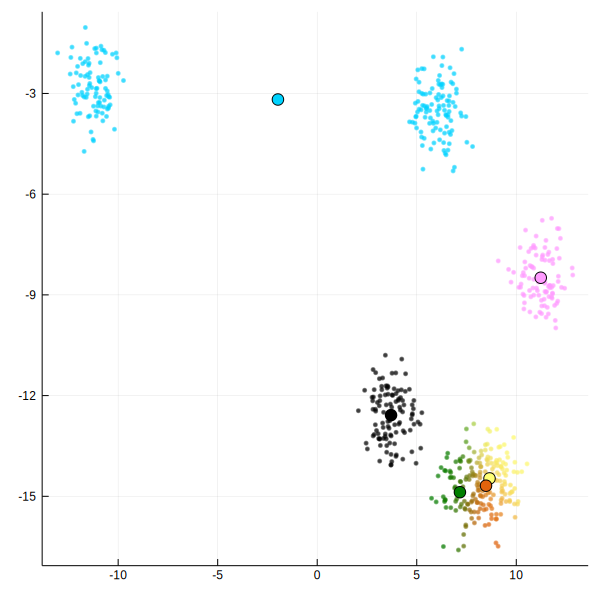

In [392]:
p = Plots.scatter(train_data[:,1],train_data[:,2],
    markersize=2,
    markercolor= col_gamma, markerstrokecolor= col_gamma, legend=false,
    markeralpha = 0.5)
Plots.scatter!(p,
    [c[1] for c = cent_clus],
    [c[2] for c = cent_clus],
    markersize=6, markercolor=col_vec, markerstrokecolor=:black, legend=false,
    size = (600,600))

In [401]:
col_vec

In [420]:
cent_clus = [[3.7087992423287637, -12.581417122936884], [7.358210079460842, -16.170489578331534], [11.229299941648044, -8.489311978956183], [-11.214161632317582, -2.806881742122954], [6.035666454881453, -3.503889772304382], [8.275872258179026, -14.601196392936425]]

6-element Array{Array{Float64,1},1}:
 [3.7087992423287637, -12.581417122936884]
 [7.358210079460842, -16.170489578331534]
 [11.229299941648044, -8.489311978956183]
 [-11.214161632317582, -2.806881742122954]
 [6.035666454881453, -3.503889772304382]
 [8.275872258179026, -14.601196392936425]

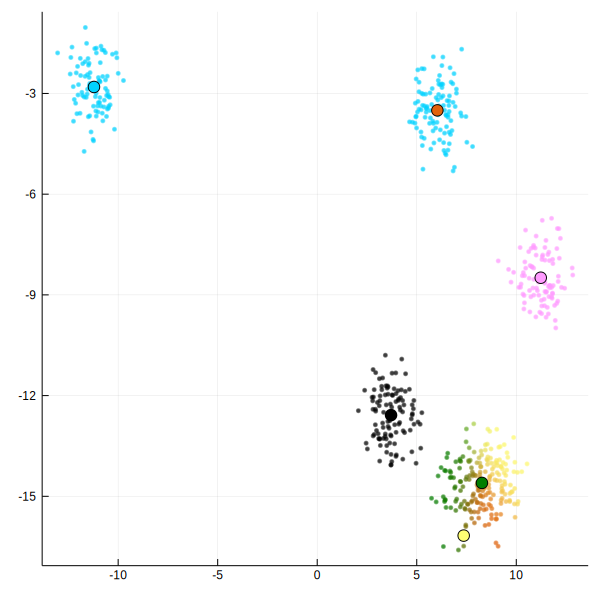

In [421]:
p = Plots.scatter(train_data[:,1],train_data[:,2],
    markersize=2,
    markercolor= col_gamma, markerstrokecolor= col_gamma, legend=false,
    markeralpha = 0.5)
Plots.scatter!(p,
    [c[1] for c = cent_clus],
    [c[2] for c = cent_clus],
    markersize=6, markercolor=col_vec, markerstrokecolor=:black, legend=false,
    size = (600,600))